## **Fine-tuning a large language model using LoRA**

In the **Training section** of this notebook, we fine-tune the TinyLlama model from Hugging Face to search for hexadecimal color codes using natural language. The model has approximately 1 billion parameters and cannot be easily trained on a local machine.

Low-rank adaptation, or LoRA, allows us to freeze all of the model parameters except for a targeted few. Specifically, the matrices responsible for the model's attention, namely the Q and V matrices, are decomposed into two low-rank matrices each and then optimized, drastically reducing the computational cost involved in full fine-tuning. The matrix pairs are then multiplied to obtain the dimensions of the original matrices and then merged into the full pretrained model as $\Delta \theta$.

In the **Analysis and Inference** section of the notebook, we:
1. Examine the learning curves to ensure proper training and convergence.
2. Visualize the model weights of the pretrained and fine-tuned matrices.
3. Test both the base and fine-tuned models with natural language queries.

<!-- ![alt text](data/art.png) -->
<center><img src="data/art.png" alt="Art" width="300" height="200"></center>

### **\# 1 Training**

In [4]:
# Import required packages
import os
import re
import torch
from trl import SFTTrainer
from time import perf_counter
from datasets import load_dataset, Dataset
from peft import AutoPeftModelForCausalLM, PeftModel
from peft import LoraConfig, AutoPeftModelForCausalLM
from transformers import EarlyStoppingCallback, TrainerCallback
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, GenerationConfig

# Define dataset and model information
dataset_id = "burkelibbey/colors"
model_id = "TinyLlama/TinyLlama-1.1B-Chat-v0.3"
output_model = "colorist"

**Load and split the dataset**

In [5]:
# Load the dataset, this one only has a training set so we will split it manually
dataset = load_dataset(f"{dataset_id}", split="train")

# Split the dataset into training and validation sets, note that should be 80 / 20
split_ratio = 0.99
num_examples = len(dataset)
split_index = int(split_ratio * num_examples)
train_data = dataset.select(indices=range(split_index))
val_data = dataset.select(indices=range(split_index, num_examples))
print(len(train_data), len(val_data))

33548 339


**Format the data for TinyLlama**

In [7]:
def prepare_data(data):
    data_df = data.to_pandas()
    data_df["text"] = data_df[["description", "color"]].apply(lambda x: "<|im_start|>user\n" + x["description"] + " <|im_end|>\n<|im_start|>assistant\n" + x["color"] + "<|im_end|>\n", axis=1)
    data = Dataset.from_pandas(data_df)
    return data

train_dataset = prepare_data(train_data)
val_dataset = prepare_data(val_data)
train_dataset[0]

**Load TinyLlama and fetch its tokenizer**

In [9]:
# Function to get model and tokenizer
def get_model_and_tokenizer(model_id):
    tokenizer = AutoTokenizer.from_pretrained(model_id) # huggingface selected tokenizer given model_id
    tokenizer.pad_token = tokenizer.eos_token # set pad token to end of string token
    model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto") # huggingface selected model given model_id,
    model.config.use_cache = False # disable cache for training since each instance does not have the same context and is separate
    model.config.pretraining_tp = 1 # no gpu so set to 1
    return model, tokenizer

model, tokenizer = get_model_and_tokenizer(model_id)

In [10]:
# tokenizer gives us an encoding of the string and the attention mask
tokenizer('I want to be an artist')

{'input_ids': [1, 306, 864, 304, 367, 385, 7664], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

**Look for the name of the attention module so we can target it with LoRA**

In [33]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32003, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Line

**Configure LoRA and which parameters to target**

In [ ]:
peft_config = LoraConfig(
    r=8, lora_alpha=16, lora_dropout=0.05, bias="none", task_type="CAUSAL_LM",
    target_modules=["q_proj", "v_proj"]
)

**Create Callbacks to save loss to CSV**

In [11]:
class SaveLossCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:  # Training loss
            self.train_losses.append(logs['loss'])
        if 'eval_loss' in logs:  # Validation loss
            self.val_losses.append(logs['eval_loss'])
    
    def on_train_end(self, args, state, control, **kwargs):
        # Save to CSV at the end of training
        import pandas as pd
        df = pd.DataFrame({
            'Train_Loss': self.train_losses,
            'Val_Loss': self.val_losses
        })
        df.to_csv(f'./{output_model}/losses.csv', index=False)

**Configure training arguments and begin fine-tuning model** 

In [ ]:
training_arguments = TrainingArguments(
        output_dir=output_model, # output directory for checkpoints
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=4,
        optim="adamw_torch",
        learning_rate=2e-4,
        lr_scheduler_type="cosine",
        save_strategy="steps",
        evaluation_strategy="steps",
        logging_steps=2,
        num_train_epochs=3,
        max_steps=200,
        logging_dir='./colorist/logs',  # Directory for TensorBoard logs
        logging_strategy="steps",
        load_best_model_at_end=True,  # Load the best model at the end of training
    )

trainer = SFTTrainer(
        model=model,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        peft_config=peft_config,
        dataset_text_field="text",
        args=training_arguments,
        tokenizer=tokenizer,
        max_seq_length=1024,
        callbacks=[SaveLossCallback()]
    )

In [ ]:
# Train the model
trainer.train()

# save trained model
trainer.save_model(output_model)

**Expand and add trained low-rank adapter to attention module**

In [ ]:
# Load the trained model
pre_trained_model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float32, load_in_8bit=False, device_map="auto", trust_remote_code=True)

# Merge the  pre-trained model with the loRA model
model_path = f"./{output_model}"
peft_model = PeftModel.from_pretrained(pre_trained_model, model_path, from_transformers=True, device_map="auto")
fine_tuned_model = peft_model.merge_and_unload().to("cpu")

# Save the fine tuned model
torch.save(fine_tuned_model.state_dict(), os.path.join(output_model, "fine_tuned_model.pt"))

### **\# 2 Analysis and Inference**

In [12]:
# Import required packages
import os
import re
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from trl import SFTTrainer
from time import perf_counter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
from datasets import load_dataset, Dataset
from peft import AutoPeftModelForCausalLM, PeftModel
from peft import LoraConfig, AutoPeftModelForCausalLM
from transformers import EarlyStoppingCallback, TrainerCallback
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, GenerationConfig

# Define dataset and model information
dataset_id = "burkelibbey/colors"
model_id = "TinyLlama/TinyLlama-1.1B-Chat-v0.3"
output_model = "colorist"

**Analyze the learning curves**

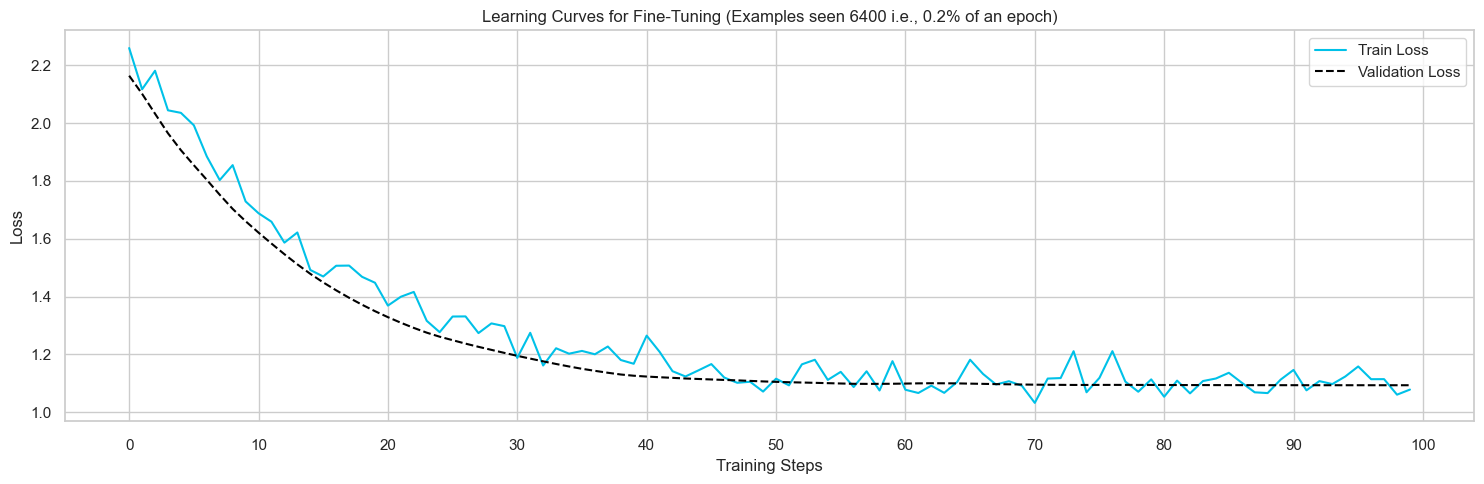

In [3]:
# Set the Seaborn theme
sns.set_theme(style="whitegrid")

# Load the CSV file
df = pd.read_csv('./colorist/losses.csv')

# Plotting
plt.figure(figsize=(15, 5))
sns.lineplot(data=df['Train_Loss'], label='Train Loss', color='#00c1e8', linestyle='-')
sns.lineplot(data=df['Val_Loss'], label='Validation Loss', color='black', linestyle='--')  

# Adding titles and labels
plt.title('Learning Curves for Fine-Tuning (Examples seen 6400 i.e., 0.2% of an epoch)')
plt.xlabel('Training Steps')
plt.ylabel('Loss')

# Customize x-axis ticks
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))  # Set major ticks interval
ax.tick_params(axis='x', which='major', length=10, width=2)  # Customize tick length and width

# Adding legend
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

**Load both the base pre-trained model and the fine-tuned model**

In [15]:
# --------Pre-train the model--------

# Load the pre-trained model
pre_trained_model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto").to('cpu')

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id) 
tokenizer.pad_token = tokenizer.eos_token

# --------Fine tune the model--------

# Load model architecture
fine_tuned_model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto").to('cpu')

# Load the state dictionary
state_dict = torch.load('colorist/fine_tuned_model.pt')

# Apply the state dictionary to the model
fine_tuned_model.load_state_dict(state_dict)

**Inspect whether model weights have shifted (numerically and visually)**

In [19]:
q_matrix1 = pre_trained_model.model.layers[0].self_attn.q_proj.weight.data[:100, :100].cpu()
q_matrix2 = fine_tuned_model.model.layers[0].self_attn.q_proj.weight.data[:100, :100].cpu()
if not torch.equal(q_matrix1, q_matrix2): print('weights have updated')
else:print('weights have not updated')

weights have updated


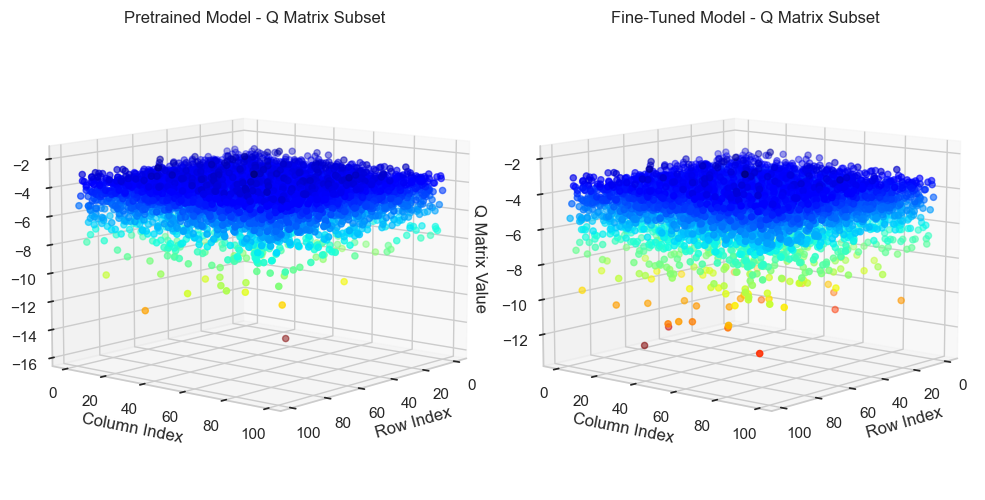

In [21]:
# Extract a subset of the Q matrices (e.g., the first 100 elements)
q_matrix_pretrained = pre_trained_model.model.layers[0].self_attn.v_proj.weight.data[:100, :100].cpu().numpy()
q_matrix_fine_tuned = fine_tuned_model.model.layers[0].self_attn.v_proj.weight.data[:100, :100].cpu().numpy()

# # Apply logarithmic scaling to the values in both Q matrices
# log_q_matrix_pretrained = np.log(q_matrix_pretrained + 10e-6)  # Add a small constant to avoid log(0)
# log_q_matrix_fine_tuned = np.log(q_matrix_fine_tuned + 10e-6)  # Add a small constant to avoid log(0)

# Get the shape of the subset
rows, cols = q_matrix_pretrained.shape

# Create a meshgrid for the rows and columns
X, Y = np.meshgrid(range(rows), range(cols))

# Flatten the Q matrix values for both matrices
Z_pretrained = log_q_matrix_pretrained.flatten()
Z_fine_tuned = log_q_matrix_fine_tuned.flatten()

# Create subplots for side-by-side comparison
fig = plt.figure(figsize=(10, 5))

# First subplot for pretrained model
ax_pretrained = fig.add_subplot(121, projection='3d', elev=10, azim=40)
ax_pretrained.scatter(X, Y, Z_pretrained, c=Z_pretrained, cmap='jet_r')
ax_pretrained.set_xlabel('Row Index')
ax_pretrained.set_ylabel('Column Index')
ax_pretrained.set_zlabel('Q Matrix Value')
ax_pretrained.set_title('Pretrained Model - Q Matrix Subset')

# Second subplot for fine-tuned model
ax_fine_tuned = fig.add_subplot(122, projection='3d', elev=10, azim=40)
ax_fine_tuned.scatter(X, Y, Z_fine_tuned, c=Z_fine_tuned, cmap='jet_r')
ax_fine_tuned.set_xlabel('Row Index')
ax_fine_tuned.set_ylabel('Column Index')
ax_fine_tuned.set_zlabel('Q Matrix Value')
ax_fine_tuned.set_title('Fine-Tuned Model - Q Matrix Subset')

# Adjust layout and show the subplots
plt.tight_layout()
plt.show()

**Analyze responses from both models**

In [38]:
# Function to format the prompt
def formatted_prompt(question)-> str:
    return f"<|im_start|>user\n{question}<|im_end|>\n<|im_start|>assistant:"


# Function to generate a response and display the hex color
def generate_response(model, tokenizer, user_input):
    prompt = formatted_prompt(user_input)
    inputs = tokenizer(prompt, return_tensors="pt").to('cpu')
    generation_config = GenerationConfig(penalty_alpha=0.6, do_sample=True,
                                         top_k=5, temperature=0.5, repetition_penalty=1.2,
                                         max_new_tokens=12, pad_token_id=tokenizer.eos_token_id) # These settings are to control the stochasticity of the model

    outputs = model.generate(**inputs, generation_config=generation_config)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract hex color from response
    hex_color_match = re.search(r'#[0-9A-Fa-f]{6}', response)
    hex_color = hex_color_match.group(0) if hex_color_match else None

    # Print and display the hex color
    if hex_color:
        print_color_space(hex_color)
    else:
        print("No hex color found in the response.")
        print(response)

# Function to print color space
def print_color_space(hex_color):
    def hex_to_rgb(hex_color):
        hex_color = hex_color.lstrip('#')
        return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    r, g, b = hex_to_rgb(hex_color)
    print(f'{hex_color}: \033[48;2;{r};{g};{b}m           \033[0m')

In [120]:
generate_response(fine_tuned_model, tokenizer, 'Give me red')

#ff0022:            


In [21]:
generate_response(fine_tuned_model, tokenizer, 'A color that reminds me of the cold winter sky')

#10c4f2:            


In [66]:
generate_response(fine_tuned_model, tokenizer, 'color like the sun')

#ffff00:            


In [118]:
generate_response(fine_tuned_model, tokenizer, 'A deep, forest green that is so dark it is almost black. There is a strong sense of tranquility and depth in this shade')

#403821:            


In [183]:
generate_response(fine_tuned_model, tokenizer, 'A vibrant rich turquoise hue that would remind one of clear, sparkling tropical waters. Bright and lively with a slight greenish undertone.')

#80c0a0:            


In [184]:
generate_response(pre_trained_model, tokenizer, 'Give me red')

No hex color found in the response.
user
Give me red 
 assistant: Red is a color that has a strong association with emotions


In [188]:
generate_response(pre_trained_model, tokenizer, 'Once apon a time')

No hex color found in the response.
user
Once apon a time 
 assistant: Once upon a time, there was a little pig named
